<a href="https://colab.research.google.com/github/kei-mo/TheoriticalNeuroscience/blob/master/Chapter8_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 9 : Classical Conditioning and Reinforcement Learning

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import random

## 9.1 Classical conditioning

### Prediction rewards: The Recorla-Wagner Rule

$v =wu$  
$w \leftarrow w + \epsilon \delta u $  
$\delta = r - u $

#### Acquire and Extinction

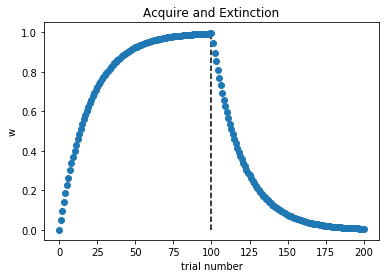

In [22]:
epsilon = 0.05
w_list = [0]

# Acquire
for i in range(0,100):
    r = 1
    u = 1
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)

# Extinction
for i in range(100,200):
    u = 1 
    r = 0
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)
    
plt.plot(w_list, "o")
plt.vlines(100,0,1,linestyle='dashed')

plt.xlabel("trial number")
plt.ylabel("w")
plt.title("Acquire and Extinction")
plt.show()

#### Partial reinforcment

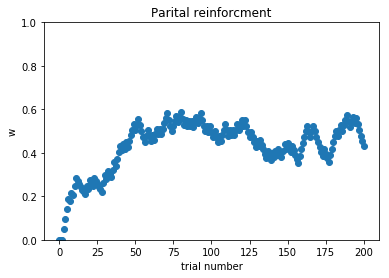

In [23]:
epsilon = 0.05
w_list = [0]
for i in range(200):
    u = 1 
    r = 1 if np.random.rand()>0.5 else 0
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)
plt.plot(w_list,"o")
plt.ylim(0,1)
plt.xlabel("trial number")
plt.ylabel("w")
plt.title("Parital reinforcment")

plt.show()

#### Blocking

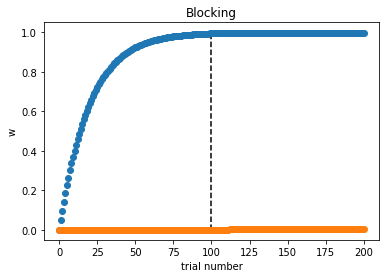

In [25]:
epsilon = 0.05
w_list = [[0,0]]

# Pretrain
r = 1
u = np.array([1,0])
for i in range(0,100):
    v = np.dot(w_list[i],u)
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)

# Train
r = 1
u = np.array([1,1])
for i in range(100,200):
    v = np.dot(w_list[i],u)
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)

    
    
plt.plot(w_list, "o")
plt.vlines(100,0,1,linestyle='dashed')
plt.xlabel("trial number")
plt.ylabel("w")
plt.title("Blocking")

plt.show()

#### Inhibitory

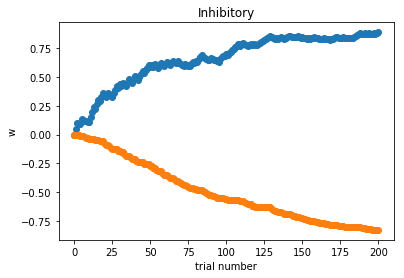

In [26]:
epsilon = 0.05
w_list = [[0,0]]

# Train
r = 1
u = np.array([1,1])
for i in range(0,200):
    if np.random.rand()>0.5:
        r = 0
        u = np.array([1,1])
        v = np.dot(w_list[i],u)
        delta = r - v
        w = w_list[i] + epsilon * delta * u
    else:
        r = 1
        u = np.array([1,0])
        v = np.dot(w_list[i],u)
        delta = r - v
        w = w_list[i] + epsilon * delta * u
    w_list.append(w)

    
    
plt.plot(w_list, "o")
plt.xlabel("trial number")
plt.ylabel("w")
plt.title("Inhibitory")

plt.show()

#### Overshadow

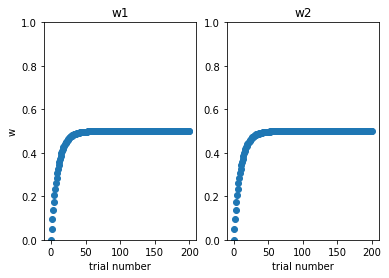

In [31]:

epsilon = 0.05
w_list = [[0,0]]

# Train
r = 1
u = np.array([1,1])
for i in range(0,200):
    r = 1
    u = np.array([1,1])
    v = np.dot(w_list[i],u)
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)

    
plt.subplot(1, 2, 1)
plt.plot(np.array(w_list)[:,0], "o")
plt.xlabel("trial number")
plt.ylabel("w")
plt.ylim(0,1)
plt.title("w1")

plt.subplot(1, 2, 2)
plt.plot(np.array(w_list)[:,1], "o")
plt.xlabel("trial number")
plt.ylim(0,1)
plt.title("w2")

plt.show()

### Temporal difference 

In [0]:
trial_num = 1000
trial_len = 250
epsilon = 0.05


stumulate_time = 10
reward_time = 20

# stiumlus
u_list = np.array([0]*trial_len)
u_list[stumulate_time] = 1

# reward
r_list = [0]*trial_len
r_list[reward_time] = 1

# weight
w_list = [0] * trial_len
# value
v_list = [0] * trial_len

delta_list = [0] * trial_len
for trial in range(trial_num):
    for t in range(trial_len - 1):
        next_v = v_list[t+1]
        v = v_list[t]
        delta = r_list[t] + next_v - v
        for tau in range(t+1):
            w_list[tau] = w_list[tau] + epsilon * delta * u_list[t-tau]
        v_list[t] = np.sum([w*u for w,u in zip(w_list[:t+1], u_list[:t+1][::-1])])

#v_history = [v_list]#
#delta_history = []

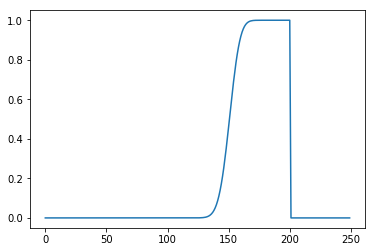

In [0]:
plt.plot(v_list)

In [0]:
# J's edition
import numpy as np
trial_num = 1000
trial_len = 250
epsilon = 0.2

stumulate_time = 10
reward_time = 30

# stiumlus
u_list = np.array([0]*trial_len)
u_list[stumulate_time] = 1
u_list[stumulate_time+3] = 1

# reward
r_list = [0]*trial_len
r_list[reward_time] = 1
r_list[reward_time+3] = 1


# weight
w_list = [0] * trial_len
# value
v_list = [0] * trial_len

delta_list = [0] * trial_len
for trial in range(trial_num):
    for t in range(trial_len - 1):
        v_list[t] = np.sum([w*u for w,u in zip(w_list[:t+1], u_list[:t+1][::-1])])
        next_v = np.sum([w*u for w,u in zip(w_list[:t+2], u_list[:t+2][::-1])])
        v = v_list[t]
        delta = r_list[t] + next_v - v
        for tau in range(t+1):
            w_list[tau] = w_list[tau] + epsilon * delta * u_list[t-tau]
        #v_list[t] = np.sum([w*u for w,u in zip(w_list[:t+1], u_list[:t+1][::-1])])

#v_history = [v_list]#
#delta_history = []

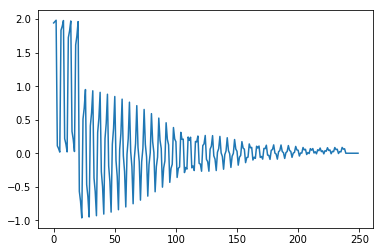

In [0]:
plt.plot(w_list)

In [0]:
epsilon = 0.05

In [0]:
for trial in range(100):
    for t in range(250-1):
        next_v = v_list[t+1]
        v = v_list[t]
        delta = r_list[t] + next_v - v
        w_list[t] = w_list[t] + epsilon * delta * u_list[t]
        v_list[t] = np.sum([w_list[t] * u for u in u_list[:t]])
        

NameError: ignored

## 9.3 Static Action Choice

**Bee Foraing Task**  
This task is simplication version of multi-armed bandit task

In [0]:
class Bandit():
    def __init__(self, arm_num):
        self.mean_reward = [0]*arm_num
        
    def return_reward(self,arm):
        reward = random.gauss(self.mean_reward[arm], 0.8)
        return reward

In [0]:
def softmax(x, beta):
    e_x = np.exp(beta*(x - np.max(x)))
    return e_x / e_x.sum()

### Indirect actor


$m_b \leftarrow m_b + \epsilon \delta $  
$\delta = r_b - m_b $

In [0]:

epsilon = 0.1
beta = 1

m = [0, 0] # action values
visit = [0,0]

# history
m_hist = [m]
visit_hist = [visit]


flower_env = Bandit(2)
flower_env.mean_reward = [1, 2]
for i in range(0,100):
    m = m.copy()
    
    action_prob = softmax(m, beta)
    action = random.choices([0,1], weights=action_prob)[0]
    reward = flower_env.return_reward(action)
    delta = reward - m[action] # delta
    m[action] = m[action] +  epsilon * delta 
    
    m_hist.append(m)
    visit_hist.append([1,0] if action==0 else [0,1])
    
    
# Change mean reward(nector volume) of each flower at t=100
flower_env.mean_reward = [2, 1]
for i in range(100,200):
    m = m.copy()
    
    action_prob = softmax(m, beta)
    action = random.choices([0,1], weights=action_prob)[0]
    reward = flower_env.return_reward(action)
    delta = reward - m[action]
    m[action] = m[action] +  epsilon * delta 
    
    m_hist.append(m)
    visit_hist.append([1,0] if action==0 else [0,1])

m_hist = np.array(m_hist)
visit_hist = np.array(visit_hist)

Values of $m_b$ and $m_y$

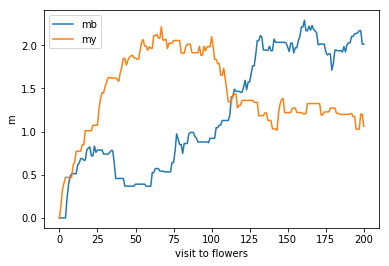

In [0]:
plt.plot(m_hist[:,0], label="mb")
plt.plot(m_hist[:,1], label="my")
plt.xlabel("visit to flowers")
plt.ylabel("m")
plt.legend()

Sum visit to flower

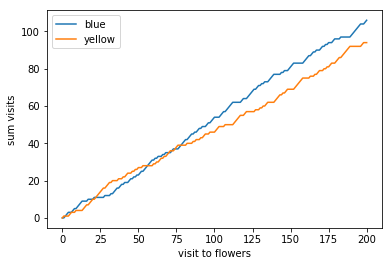

In [0]:
plt.plot(visit_hist[:,0].cumsum(), label="blue")
plt.plot(visit_hist[:,1].cumsum(), label="yellow")
plt.xlabel("visit to flowers")
plt.ylabel("sum visits")
plt.legend()

### Direct actor

In [0]:

epsilon = 0.1
beta = 1
r_bar = 1.5

m = [0.0, 0.0] # action values
visit = [0,0]

# history
m_hist = [m]
visit_hist = [visit]


flower_env = Bandit(2)
flower_env.mean_reward = [1, 2]
for i in range(0,100):
    m = m.copy()
    
    action_prob = softmax(m, beta)
    action = random.choices([0,1], weights=action_prob)[0]
    reward = flower_env.return_reward(action)
    
    
    kdb = 1 if action==0 else 0
    kdy = 1 if action==1 else 0 
    m[0] = m[0] + epsilon * (kdb - action_prob[0]) * (reward - r_bar)
    m[1] = m[1] + epsilon * (kdy - action_prob[1]) * (reward - r_bar)
    
    m_hist.append(m)
    visit_hist.append([1,0] if action==0 else [0,1])
    
    
# Change mean reward(nector volume) of each flower at t=100
flower_env.mean_reward = [2, 1]
for i in range(100,300):
    m = m.copy()
    
    action_prob = softmax(m, beta)
    action = random.choices([0,1], weights=action_prob)[0]
    reward = flower_env.return_reward(action)

    
    
    kdb = 1 if action==0 else 0
    kdy = 1 if action==1 else 0 
    m[0] = m[0] + epsilon * (kdb - action_prob[0]) * (reward - r_bar)
    m[1] = m[1] + epsilon * (kdy - action_prob[1]) * (reward - r_bar)
    
    
    m_hist.append(m)
    visit_hist.append([1,0] if action==0 else [0,1])

m_hist = np.array(m_hist)
visit_hist = np.array(visit_hist)

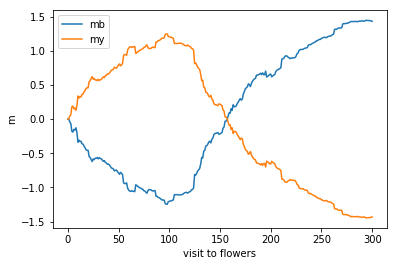

In [0]:
plt.plot(m_hist[:,0], label="mb")
plt.plot(m_hist[:,1], label="my")
plt.xlabel("visit to flowers")
plt.ylabel("m")
plt.legend()

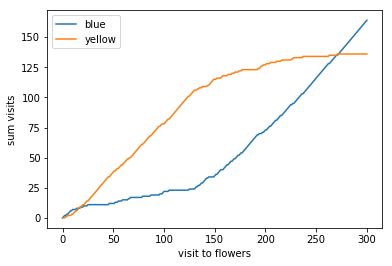

In [0]:
plt.plot(visit_hist[:,0].cumsum(), label="blue")
plt.plot(visit_hist[:,1].cumsum(), label="yellow")
plt.xlabel("visit to flowers")
plt.ylabel("sum visits")
plt.legend()